# SPEECH - EMOTION - RECOGNITION

# What does it mean?¶
Language has a very broad scope. Besides being used as a communication medium, language can also be interpreted to convey the expression of emotions and feelings of humans to humans, humans to animals, or humans with their surroundings. Language processing has 2 approaches, the first is semantic and the second is emotional. In general, the base level in spoken language is for understanding humans being what talking about, but the one level above it is an emotional approach that more considered. So, fellow parties can respond the emotions and built it up to make the interaction occurs. Here, we can say that emotions have an important role in everyday human (or other living) interactions.

Speech Recognition is not the new technology. Previously is already developed various technologies that combine natural language with computer machines, but without emotions involved inside. If we trace back, emotions are used to response the words given by the first party. This is the reasons why researchers developed a new technology known as Speech Emotion Recognition (SER). SER is a technology that tries to extract sound signals from a speech made by a computer with involving and detecting the emotional activity contained in a speech.

# Why do we need them?¶
In the psychological, emotions are one of the most difficult concepts to define. So, why is an emotion necessary and important to be defined? As we discussed earlier, emotions have an important role in shaping an interaction between humans and humans or the surrounding environment. When SER was first developed, its main objective was for the needs of human psychology research. Another goal is to develop AI as a breakthrough from previous Speech Recognition (SE without involving emotions). Nowadays, in addition to psychological research needs, SER can also be applied in the areas of entertainment, security, banking, call centers, etc.



# lets start the code 

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import soundfile
import os, glob, pickle
import numpy as np

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# DATASET

Processing and classifying voice data is a challenging because it will be a bit heavy on the labeling part. This is because everyone has different perspectives on emotions. This time we will use the RAVDESS dataset (The Ryerson Audio-Visual Database of Emotional Speech and Song) which is a voice recording dataset of 24 actors (male and female). This voice recording voiced two statements in a neutral North American accent. Speech sounds include expressions of calm, happiness, sadness, anger, fear, surprise, and disgust. Each expression is produced at two levels of emotional intensity (normal, strong), with additional neutral expressions. RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440 data.

If you look at the name of each sound file, you will find a sequence of numbers that is a file recognition / identity code. The following is the identification of the file names in the RAVDESS dataset in accordance with the documentation on the [Zenodo] website (https://zenodo.org/record/1188976):



In [2]:
RAV = "Documents/archive/"
dir_list = os.listdir(RAV)
dir_list.sort()


In [3]:
emotion = []
gender = []
path = []

for i in dir_list:
    speech_name = os.listdir(RAV + i)
    for speech in speech_name:
        part = speech.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + speech)
        
ravdess = pd.DataFrame(emotion)
ravdess = ravdess.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
ravdess = pd.concat([pd.DataFrame(gender),ravdess],axis=1)
ravdess.columns = ['gender','emotion']
ravdess['label'] = ravdess['gender'] + '_' + ravdess['emotion']
ravdess = pd.concat([ravdess,pd.DataFrame(path, columns = ['path'])],axis=1)
ravdess = ravdess.drop(['gender', 'emotion'], axis=1)
ravdess.head()


,label,path
0,male_neutral,Documents/archive/Actor_01/03-01-01-01-01-01-0...
1,male_neutral,Documents/archive/Actor_01/03-01-01-01-01-02-0...
2,male_neutral,Documents/archive/Actor_01/03-01-01-01-02-01-0...
3,male_neutral,Documents/archive/Actor_01/03-01-01-01-02-02-0...
4,male_neutral,Documents/archive/Actor_01/03-01-02-01-01-01-0...


In [4]:
ravdess.label.value_counts()


female_neutral     144
male_neutral       144
female_angry        96
female_disgust      96
female_happy        96
male_angry          96
female_fear         96
male_sad            96
female_surprise     96
female_sad          96
male_surprise       96
male_disgust        96
male_happy          96
male_fear           96
Name: label, dtype: int64

Okay, we have got a label for each speech file. The following is an example of one of the speeches and emotions spoken by the actor who is complemented by the sound waves. We will see the pattern of surprised expressions.



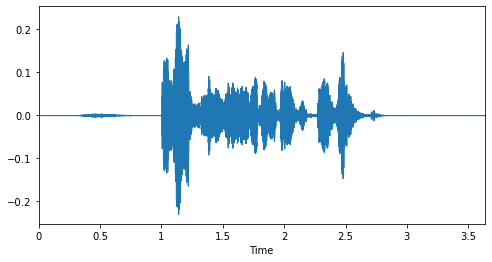

In [5]:
speech_name = RAV + 'Actor_24/03-01-08-02-02-02-24.wav'  
data, sampling_rate = librosa.load(speech_name)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(speech_name)

# Feature Extraction¶
Here we go! Feature extraction is one of the determining parts in the success of the classification model later. At this stage, we use MFCC to extract voice features in our data. The MFCC coefficient to be used is 13


In [6]:
from tqdm import tqdm
input_duration=3
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(ravdess))):
    X, sample_rate = librosa.load(ravdess.path[i], res_type='kaiser_fast',duration=input_duration,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]


100%|██████████| 1440/1440 [02:03<00:00, 11.65it/s]


In [7]:
data.to_pickle("mfcc13_result.pkl")
data = pd.read_pickle("mfcc13_result.pkl")
data.head()


,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."


In [8]:
mfcc_result = pd.concat([ravdess,pd.DataFrame(data['feature'].values.tolist())],axis=1)
mfcc_result = mfcc_result.fillna(0)
mfcc_result.head()


,label,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,male_neutral,Documents/archive/Actor_01/03-01-01-01-01-01-0...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male_neutral,Documents/archive/Actor_01/03-01-01-01-01-02-0...,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male_neutral,Documents/archive/Actor_01/03-01-01-01-02-01-0...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_neutral,Documents/archive/Actor_01/03-01-01-01-02-02-0...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_neutral,Documents/archive/Actor_01/03-01-02-01-01-01-0...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769


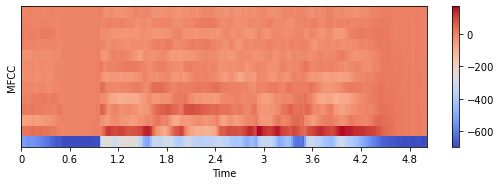

In [9]:
X, sample_rate = librosa.load(speech_name, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
plt.figure(figsize=(20, 15))
plt.subplot(5,2,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

 # Splitting Data
Split data used to separate our data into data train and data test. We use 80:20 comparison where the side that is widely used for data train. We use the 80:20 ratio, where 80% of the data will be used for the data train.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_result.drop(['label','path'],axis=1)
                                                    , mfcc_result.label
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=14)

# Lets see how the data present itself before normalisation 
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
927,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,-62.068012,...,-48.247292,-53.606144,-55.738834,-48.427902,-47.056660,-49.552917,-50.843132,-52.660881,-53.786362,-55.845634
720,-67.695282,-67.695282,-67.695282,-66.014351,-64.587204,-67.108223,-64.659668,-61.150452,-60.628960,-61.321541,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1309,-55.011543,-54.920540,-55.621944,-56.828728,-56.848660,-56.117332,-55.148472,-54.941704,-55.024555,-53.665115,...,-51.779953,-51.660950,-53.346821,-56.588219,-56.599403,-56.620682,-54.343609,-55.447041,-56.740005,-56.740005
1413,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,-49.019577,...,-42.656292,-42.299309,-42.581753,-45.421638,-46.908676,-46.339077,-47.499138,-48.954853,-49.019577,-49.019577
248,-58.864403,-58.654854,-60.989502,-65.154793,-61.926540,-60.033833,-62.113197,-68.919891,-73.609833,-72.388657,...,-38.556309,-35.909000,-36.434357,-38.448009,-38.692501,-40.448235,-37.214626,-31.462624,-31.119629,-30.882038


In [11]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(X_train.shape)
print(lb.classes_)

(1152, 259)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [12]:
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape


(1152, 259, 1)

# build the model 

In [13]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 259, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 259, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=70, validation_data=(X_test, y_test))


Epoch 1/70
72/72 [==============================] - 23s 325ms/step - loss: 2.3316 - accuracy: 0.2066 - val_loss: 2.1926 - val_accuracy: 0.2118
Epoch 2/70
72/72 [==============================] - 22s 312ms/step - loss: 2.0480 - accuracy: 0.2778 - val_loss: 2.1570 - val_accuracy: 0.2396
Epoch 3/70
72/72 [==============================] - 23s 314ms/step - loss: 1.8971 - accuracy: 0.2960 - val_loss: 2.0791 - val_accuracy: 0.2847
Epoch 4/70
72/72 [==============================] - 23s 320ms/step - loss: 1.8117 - accuracy: 0.3168 - val_loss: 1.9348 - val_accuracy: 0.3021
Epoch 5/70
72/72 [==============================] - 22s 312ms/step - loss: 1.7773 - accuracy: 0.3420 - val_loss: 1.9522 - val_accuracy: 0.2708
Epoch 6/70
72/72 [==============================] - 23s 319ms/step - loss: 1.6918 - accuracy: 0.3628 - val_loss: 1.9032 - val_accuracy: 0.2986
Epoch 7/70
72/72 [==============================] - 24s 330ms/step - loss: 1.6311 - accuracy: 0.3924 - val_loss: 1.8461 - val_accuracy: 0.3333

In [15]:
model.save('model2_70ep')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model2_70ep\assets


In [16]:
from tensorflow import keras
model = keras.models.load_model('model2_70ep')


In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


accuracy: 43.75%


In [18]:
preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)
preds=preds.argmax(axis=1)

18/18 [==============================] - 1s 57ms/step


In [19]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predicted_values': preds})

actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actual_values': actual})


compare_table = actual.join(preds)
compare_table.head()


,actual_values,predicted_values
0,male_disgust,male_surprise
1,male_sad,female_disgust
2,female_happy,female_surprise
3,female_neutral,female_neutral
4,female_neutral,female_neutral


In [20]:
compare_table['actual_values'].value_counts()

male_neutral       32
female_surprise    26
female_neutral     26
female_happy       25
female_angry       21
male_happy         20
male_fear          20
male_surprise      20
female_fear        18
female_disgust     18
male_disgust       17
female_sad         16
male_angry         16
male_sad           13
Name: actual_values, dtype: int64

In [21]:
table_conf = confusion_matrix(compare_table['actual_values'], compare_table['predicted_values'])


In [22]:
class_target = compare_table['actual_values'].unique()
class_target.sort()


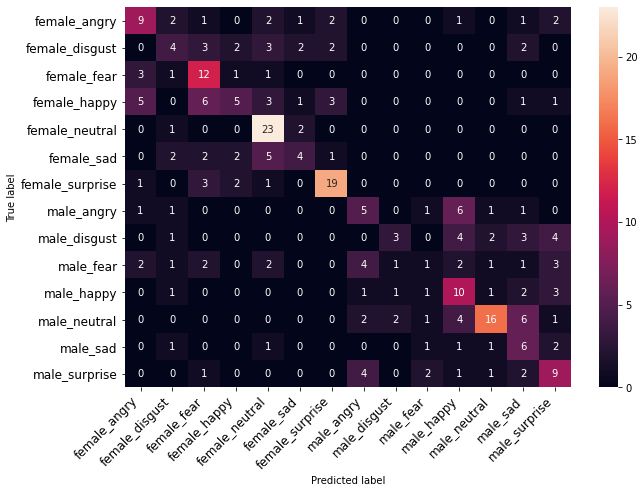

In [23]:
def confusion_matrix_result(confusion_matrix, class_names, figsize = (10,7), fontsize=12):
    import seaborn as sns
    conf = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
confusion_matrix_result(table_conf, class_names = class_target)

# live demo

In [71]:

import pyaudio
import wave
 
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "sad_test.wav"
device_index = 2
audio = pyaudio.PyAudio()

print("----------------------record device list---------------------")
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
print(numdevices)
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

print("-------------------------------------------------------------")

index = int(input())
print("recording via index "+str(index))

stream = audio.open(format=FORMAT, channels=CHANNELS,rate=RATE, input=True,input_device_index = index,frames_per_buffer=CHUNK)

print ("recording started")
Recordframes = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    Recordframes.append(data)
print ("recording stopped")
 
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(Recordframes))
waveFile.close()

----------------------record device list---------------------
4
Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek Audio)
-------------------------------------------------------------
1
recording via index 1
recording started
recording stopped


In [72]:

data, sampling_rate = librosa.load('sad_test.wav')
ipd.Audio('sad_test.wav')


In [73]:
X, sample_rate = librosa.load('sad_test.wav'
                              ,res_type='kaiser_fast'
                              ,duration=3
                              ,sr=44100
                              ,offset=0.5)

sample_rate = np.array(sample_rate)
mfcc_test = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40),axis=0)
mfcc_test = pd.DataFrame(data=mfcc_test).T
mfcc_test


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-1.683492,-3.109599,-8.120126,-7.788478,-8.492452,-8.460588,-8.067894,-8.351701,-9.009929,-8.000494,...,-6.268734,-6.419185,-5.846432,-6.453794,-7.358869,-8.131899,-7.470525,-7.652925,-7.238041,-5.994203


In [74]:
mfcc_test= np.expand_dims(mfcc_test, axis=2)
pred_test = model.predict(mfcc_test, 
                         batch_size=16, 
                         verbose=0)

pred_test

array([[1.5654433e-25, 1.3089918e-15, 3.0523825e-06, 3.8105498e-14,
        1.5962240e-07, 2.5691821e-10, 8.1807104e-18, 0.0000000e+00,
        8.0439775e-22, 1.2514937e-25, 0.0000000e+00, 3.9178617e-26,
        9.9999678e-01, 3.3550215e-36]], dtype=float32)

In [75]:
result = pred_test.argmax(axis=1)
result = result.astype(int).flatten()
result = (lb.inverse_transform((result)))
result

array(['male_sad'], dtype=object)

# Conclusions¶
Building a machine learning model for sound processing is arguably not easy. The feature extraction process really determines how well the model is created. Choosing the wrong features can cause our model to be less precise in predicting emotional classes